# Рекурентная нейронная сеть, предсказывающая прогноз поведения курса на основании [Volume Weighted Average Price (VWAP)](https://www.investopedia.com/terms/v/vwap.asp)



### *Подгружаем зависимости*


In [2]:
%matplotlib inline

import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.6
pandas==1.0.3
numpy==1.18.1
sklearn==0.22.1
torch==1.4.0
matplotlib==3.1.3


In [4]:
import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab


## Торговые данные

Анализируем данные по всем сделкам на MOEX. 
Скачать данные можно по [ссылке](https://www.finam.ru/profile/moex-akcii/sberbank/export/).


In [5]:
files = sorted(glob.glob('data/input/stocks/sber/*.csv'))
files

['data/input/stocks/sber\\SBER_200401_200410.csv',
 'data/input/stocks/sber\\SBER_200411_200420.csv',
 'data/input/stocks/sber\\SBER_200421_200430.csv',
 'data/input/stocks/sber\\SBER_200501_200510.csv']

In [6]:
df = pd.concat(map(lambda f: pd.read_csv(f, sep=';', header=0, index_col=0,
                                         names=['ticker', 'per','date', 'time', 'price', 'vol'],
                                         parse_dates = {'timestamp': [2, 3]}), files))
print(df.shape)
df.head()


(2453396, 4)


ticker  per  price  vol
timestamp                                  
2020-04-01 09:59:59   SBER    0  183.2  130
2020-04-01 09:59:59   SBER    0  183.2  130
2020-04-01 09:59:59   SBER    0  183.2  310
2020-04-01 09:59:59   SBER    0  183.2   10
2020-04-01 09:59:59   SBER    0  183.2  690

In [7]:
df.shape

(2453396, 4)

Каждая строка представляет собой одну сделку:
Нас интересуют только три колонки: {timestamp}, {price} и {vol}
- *timestamp* -> время совершения сделки с точностью до секунд,
- *price* -> цена актива в сделке,
- *vol* -> количество лотов, участвующих в сделке - объем сделки


### *Предобработка данных (очистка)*



In [8]:
df[(df.index > "2020-04-13 18:49:12") & (df.index < "2020-04-14 09:59:00")]

Empty DataFrame
Columns: [ticker, per, price, vol]
Index: []

In [8]:
df.dtypes

ticker     object
per         int64
price     float64
vol         int64
dtype: object

In [9]:
df_vol = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: np.sum(row.vol)
).to_frame()
df_vol.columns=['vol']
df_vol.head()

vol
timestamp                   
2020-04-01 09:59:00   373770
2020-04-01 10:00:00  1777620
2020-04-01 10:01:00   909890
2020-04-01 10:02:00   781060
2020-04-01 10:03:00  1627750

In [16]:
print(df_vol.shape)
df_vol.loc[df_vol['vol'] == 0]

#df_vol[df_vol.index < "2020-04-14 09:59:00"]

(53811, 1)


vol
timestamp               
2020-04-01 18:40:00    0
2020-04-01 18:41:00    0
2020-04-01 18:42:00    0
2020-04-01 18:43:00    0
2020-04-01 18:44:00    0
...                  ...
2020-05-08 18:40:00    0
2020-05-08 18:41:00    0
2020-05-08 18:42:00    0
2020-05-08 18:43:00    0
2020-05-08 18:44:00    0

[39662 rows x 1 columns]

In [10]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: np.sum(row.price * row.vol) / np.sum(row.vol)
)
df_vwap.head()

C:\Python\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


timestamp
2020-04-01 09:59:00    183.200000
2020-04-01 10:00:00    182.706973
2020-04-01 10:01:00    183.330206
2020-04-01 10:02:00    183.271174
2020-04-01 10:03:00    182.807755
dtype: float64

In [16]:
print(df_vwap.shape)
print(type(df_vwap))
df_vwap.head(3)
#df_vwap.where(df_vwap ==  0)

(53811,)
<class 'pandas.core.series.Series'>


timestamp
2020-04-01 09:59:00    183.200000
2020-04-01 10:00:00    182.706973
2020-04-01 10:01:00    183.330206
dtype: float64

In [17]:
ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2020-04-21", linestyle="--", c="black")
ax.axvline("2020-05-01", linestyle="--", c="black")

Удаляем NaN значения

In [11]:
print(df_vwap.shape)
df_vwap.dropna(inplace=True)
print(df_vwap.shape)

(53811,)
(14149,)


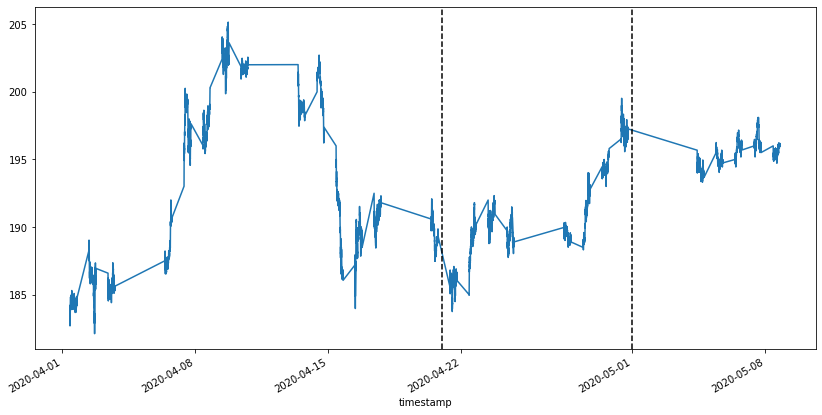

In [19]:
ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2020-04-21", linestyle="--", c="black")
ax.axvline("2020-05-01", linestyle="--", c="black")

График, показывающий изменения индекса VWAP с 11.04.2020 по 11.05.2020. 
Этот набор данных нужно разбить на три части:
`{Train_data} {Validation_data} and {Test_data}`


In [12]:
df_train = df_vwap[df_vwap.index < "2020-04-25"].to_frame(name="vwap")
df_train.shape

(9468, 1)

In [13]:
df_val = df_vwap[(df_vwap.index >= "2020-04-25") & (df_vwap.index < "2020-05-01")].to_frame(name="vwap")
df_val.shape

(2104, 1)

In [14]:
df_test = df_vwap[df_vwap.index >= "2020-05-01"].to_frame(name='vwap')
print(df_test.shape)
print(type(df_test))

(2577, 1)
<class 'pandas.core.frame.DataFrame'>


### *Масштибирование данных* 

Для более быстрой сходимости и устранения "gradient exploding effect"

Подробнее про StandartScaler [тут](https://datascience.stackexchange.com/a/12346)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# fit = scaler.fit(df_train)
# print(fit.mean_)
# print(fit.scale_)
# print(fit.var_)
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)
# print('test_arr')
# print(test_arr)
# s = StandardScaler()
# s.mean_ = fit.mean_
# s.scale_ = fit.scale_
# s.var_ = fit.var_
# test_arr_s = s.transform(df_test)
# print('test_arr_s')
# print(test_arr_s)

### *Построение входных данных*

После калибровки данных (масштабирования) - необходимо их представить в нужном виде. Т.е. в виде последовательностей

In [16]:
from torch.autograd import Variable

In [17]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [18]:
seq_len = 5

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)
x_train.size()

torch.Size([9463, 5])

In [19]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_train[0][:3])
print(y_train[0][:3])

print(x_val.shape)
print(y_val.shape)

torch.Size([9463, 5])
torch.Size([9463, 5])
tensor([-1.4967, -1.5797, -1.4747])
tensor([-1.5797, -1.4747, -1.4847])
torch.Size([2099, 5])
torch.Size([2099, 5])


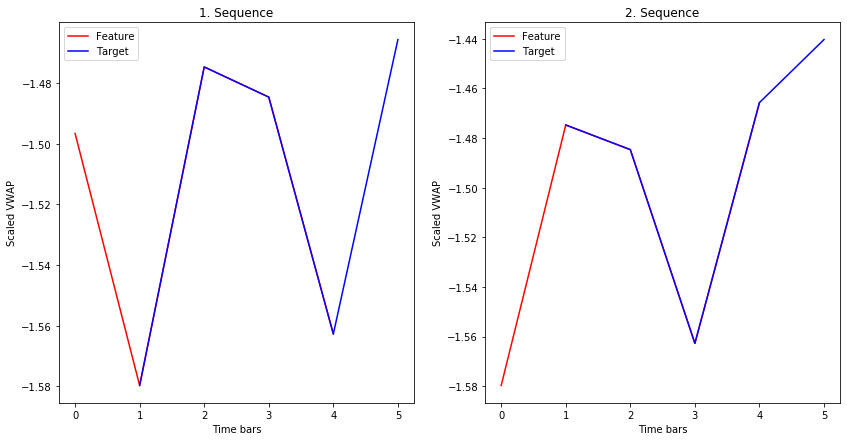

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

## *Построение модели `LSTM`*

In [22]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        # [batch_size][seq_len] -> ... -> lstm(x) -> h -> linear(h) -> prediction -> [][seq_len]
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        # ['A', 'B', 'C']
        # (1, 'A')
        # batchSize x seq_len
        # len(outputs) == batchSize
        # 
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t) #brtch size, 1
            outputs += [output]
        # [y_1, ..., y_m] -> y_j = F(y_1*, ..., y_(j-1)*) =
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

## *Класс-обертка на модель для тестирования с разными гипер-параметрами*

In [37]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=1,
        do_teacher_forcing=None,
    ):
        # x_train[0] = [1,2, 3,-1, -.1, ... , 1]
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                #with torch.no_grad():
                #print('For batch %d y_pred = %.2f' % (batch, np.average(y_pred.detach())))

                self.optimizer.zero_grad()
                # print(y_pred.shape)
                # print(y_batch.shape)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward() # В DCG -> посчитай градиент у всех Variable-node
                self.optimizer.step() # Шагни со своим шагом @lr и обнови параметры всех Variable-node
                train_loss += loss.item() # error_1 + error_2 + ... + error_{batch_size}
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)
            
            print("train_losses", self.train_losses)
            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            # Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad(): # Не запоминай в графе DCG градиенты
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        loss_fn_sum =  nn.MSELoss(reduction='sum')
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                #loss = self.loss_fn(y_pred, y_batch)
                loss = loss_fn_sum(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [24]:
def generate_sequence(scaler, model, x_sample, future=1):
    """ Generate future values for x_sample with the model """
    # Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [25]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

## Обучение и подбор параметров

### Вариант номер раз. 

```
TeacherForcing==False
```

In [38]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss() #see nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [39]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False, n_epochs=10)

train_losses [0.7643246021402138]
Epoch 1 Train loss: 0.76. Validation loss: 0.12. Avg future: 0.00. Elapsed time: 1.58s.
train_losses [0.7643246021402138, 0.31219300222132473]
Epoch 2 Train loss: 0.31. Validation loss: 0.10. Avg future: 0.00. Elapsed time: 0.84s.
train_losses [0.7643246021402138, 0.31219300222132473, 0.17904278425680054]
Epoch 3 Train loss: 0.18. Validation loss: 0.05. Avg future: 0.00. Elapsed time: 0.83s.
train_losses [0.7643246021402138, 0.31219300222132473, 0.17904278425680054, 0.13343468481444462]
Epoch 4 Train loss: 0.13. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 0.85s.
train_losses [0.7643246021402138, 0.31219300222132473, 0.17904278425680054, 0.13343468481444462, 0.09279390169502867]
Epoch 5 Train loss: 0.09. Validation loss: 0.02. Avg future: 0.00. Elapsed time: 0.84s.
train_losses [0.7643246021402138, 0.31219300222132473, 0.17904278425680054, 0.13343468481444462, 0.09279390169502867, 0.06807774587744667]
Epoch 6 Train loss: 0.07. Validation loss

In [39]:
# print(x_val[0:3])
# print(y_val[0:3])
print(x_val.shape)
print(x_val[0:1].shape)
result = generate_sequence(scaler, model_1, x_val[0:1])
print('result:')
print(type(result))
print(result)

print('y_val_unscaled:')
y_val_unscaled = scaler.inverse_transform(y_val[0:1])
print(y_val_unscaled)

torch.Size([2054, 50])
torch.Size([1, 50])
result:
<class 'numpy.ndarray'>
[[191.44361052 191.18802859 190.9013532  190.63354121 190.39551039
  190.23923639 190.1089964  190.08080672 190.04041625 189.94944707
  189.86518615 189.79145218 189.76122092 189.77324536 189.76319333
  189.80238207 189.78692099 189.73083242 189.62225747 189.44032797
  189.28616328 189.15229297 189.08606941 189.06326826 189.03498978
  189.04086227 189.02709342 189.05013902 189.04088915 189.0140183
  188.97929283 188.98582366 189.02338102 189.10335468 189.23365851
  189.37373225 189.46792192 189.54363608 189.62463477 189.68665083
  189.71203305 189.67717456 189.62579777 189.60710063 189.55058277
  189.48442165 189.47144541 189.44163159 189.43348476 189.44095856
  189.38850208]]
y_val_unscaled:
[[190.00134 190.09724 190.10388 190.04422 190.16304 190.07994 190.33142
  190.17972 189.90456 189.86156 189.83304 189.93835 190.05597 189.93938
  190.11969 189.90536 189.73918 189.50623 189.14915 189.15234 189.10858
  189.2

In [40]:
actual, predicted, test_loss = optimization_1.evaluate(x_test, y_test, batch_size=2, future=0)
print(test_loss)

0.1812627877129062


In [7]:
dict = {'SBER' : {'5Min': None, '1Min': None}, 'GAZP' :None }
print(dict['SBER']['5Min'])
dict['SBER']['5Min'] = "model_1"
print(dict['SBER']['5Min'])

None
model_1


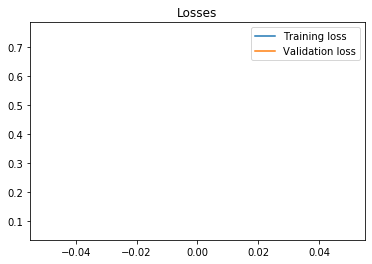

In [71]:
optimization_1.plot_losses()

In [32]:
print(x_test.shape)

actual, predicted, test_losses = optimization_1.evaluate(x_test, y_test, 100)

print(len(actual))
print(len(predicted))
print(test_losses)

torch.Size([2477, 100])
2400
2400
0.04519657029405884


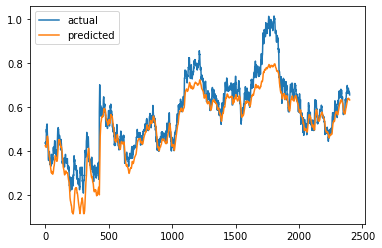

In [52]:
plt.plot(actual, label='actual')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()

### Вариант номер два.


```
TeacherForcing==True
```

step_size: at how many multiples of epoch you decay:

1.   step_size = 1, after every 1 epoch, new_lr = lr*gamma 
2.  step_size = 2, after every 2 epoch, new_lr = lr*gamma

Читать https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/

In [ ]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)

In [ ]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True, n_epochs=10)

In [ ]:
print(x_test[0:2][:10])
print(y_test[0:2][:10])
print(x_test.shape)
result = generate_sequence(scaler, model_2, x_test)
print(type(result))
print(result)
print("actual")
y_test_unscaled = scaler.inverse_transform(y_test)
print(y_test_unscaled)

In [ ]:
print(optimization_2.train_losses)
print(optimization_2.val_losses)


In [ ]:
model_3 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-3)
scheduler_3 = optim.lr_scheduler.StepLR(optimizer_3, step_size=5, gamma=0.1)
optimization_3 = Optimization(model_3, loss_fn_3,  optimizer_3, scheduler_3)

In [ ]:
optimization_3.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True, n_epochs=10)
